In [1]:
!pip3 install opencv-python numpy mediapipe scipy

In [2]:
import cv2
import numpy as np
import mediapipe as mp
import os
from scipy.signal import butter, filtfilt

LPF(LOW-PASS)

In [3]:
CUTOFF_FREQ = 0.08  
ORDER = 4           

# --- SETUP MEDIAPIPE --
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
def apply_butterworth_filter(data, cutoff_freq, order):
    """Fungsi ini adalah alat pembersih (LPF) yang membuat sinyal gerakan halus."""
    nyq = 0.5
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    data_filtered = data.copy()
    
    if data_filtered.shape[0] < 3:
        # Menangani sekuens yang terlalu pendek
        return data_filtered
        
    for j in range(data_filtered.shape[1]):
        signal = data_filtered[:, j]
        # Menggunakan filtfilt untuk zero-phase filtering
        data_filtered[:, j] = filtfilt(b, a, signal)
        
    return data_filtered

In [4]:
def extract_keypoints(results):
    """Ambil cuma titik-titik pintar di tangan, jangan lihat kepala/badan."""
    # Ekstraksi keypoints tangan kiri (21 landmark * 3 koordinat)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    # Ekstraksi keypoints tangan kanan (21 landmark * 3 koordinat)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    # Gabungkan semua keypoints menjadi satu array
    return np.concatenate([lh, rh])

In [5]:
def process_video_for_filtering(video_path, output_filename):
    """Alur utama: Baca film, ambil titik tangan, cuci bersih, dan simpan."""
    
    # PENGATURAN UKURAN TAMPILAN BARU 
    
    NEW_WIDTH = 960  
    NEW_HEIGHT = 540 
    
    if not os.path.exists(video_path):
        print(" ERROR: File video tidak ditemukan di: {video_path}")
        return

    print("Mencoba membuka file video di: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    # --- PENTING: CEK APAKAH VIDEO BENAR-BENAR TERBUKA ---
    if not cap.isOpened():
        print("ERROR BERAT: OpenCV TIDAK DAPAT MEMBUKA FILE VIDEO.")
        print("Cek 1: Pastikan alamat file di 'VIDEO_FILE' sudah 100% benar.")
        print("Cek 2: Coba ganti video dengan format lain (.mp4 standar) atau rekam ulang.")
        return

    all_keypoints = []
    print("✅ Berhasil membuka video. Mulai proses frame...")
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                # Jika ret=False, berarti video sudah habis atau gagal dibaca
                break
                
            # Proses deteksi 
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Gambar titik tangan (Visualisasi)
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            
            # Ekstraksi dan penyimpanan keypoints
            keypoints = extract_keypoints(results)
            all_keypoints.append(keypoints)
            
            frame_count += 1
            
            # BAGIAN BARU: MENGUBAH UKURAN HANYA UNTUK TAMPILAN
            # Interpolation=cv2.INTER_AREA digunakan untuk memperkecil gambar (zoom out)
            display_image = cv2.resize(image, (NEW_WIDTH, NEW_HEIGHT), interpolation=cv2.INTER_AREA)

            cv2.putText(display_image, f'Frame ke: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Menampilkan frame yang sudah diubah ukurannya
            cv2.imshow('Sedang Mencuci Film (UKURAN TAMPILAN: {}x{})'.format(NEW_WIDTH, NEW_HEIGHT), display_image)

            # Waitkey adalah yang membuat jendela tetap terbuka
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    
    if not all_keypoints:
        print("Peringatan: Tidak ada frame yang berhasil diproses.")
        return

    # Proses Filtering dan Penyimpanan
    sequence_array = np.array(all_keypoints)
    print(f"\nTotal gerakan yang diambil: {sequence_array.shape[0]} frame.")
    print(f"Sekarang mulai mencuci bersih (Low-Pass Filter)...")
    filtered_sequence = apply_butterworth_filter(sequence_array, CUTOFF_FREQ, ORDER)
    np.save(output_filename, filtered_sequence)
    
    print("Selesai! Film sudah bersih!")
    print(f"Data gerakan tangan clean di: {output_filename}")

    

In [6]:
if __name__ == "__main__":
    
    # Tanda \\ (dua backslash) harus digunakan.
    VIDEO_FILE = 'D:\\PSD_UAS\\saya1.mp4'
    
    OUTPUT_FILE = 'LPF_BERSIH_SAYA1.npy'
    
    process_video_for_filtering(VIDEO_FILE, OUTPUT_FILE)

Mencoba membuka file video di: {video_path}
✅ Berhasil membuka video. Mulai proses frame...


c:\Users\ARIMBY\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



Total gerakan yang diambil: 530 frame.
Sekarang mulai mencuci bersih (Low-Pass Filter)...
Selesai! Film sudah bersih!
Data gerakan tangan clean di: LPF_BERSIH_SAYA1.npy


Moving Average

In [7]:
import os

In [8]:
WINDOW_SIZE = 5     # Contoh: Ambil rata-rata dari 5 frame terakhir

#SETUP MEDIAPIPE
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [9]:
def apply_moving_average_filter(data, window_size):
    """
    Fungsi ini menerapkan Moving Average Filter (Rata-rata Bergerak) 
    pada data keypoints untuk menghaluskan sinyal.
    """
    if data.shape[0] < window_size:
        # Jika data terlalu pendek, kembalikan data asli
        print("🚨 Peringatan: Data terlalu pendek untuk Moving Average. Mengembalikan data asli.")
        return data.copy()
        
    data_filtered = data.copy()
    
    # Iterate melalui setiap kolom (yaitu, setiap koordinat x, y, z dari setiap landmark)
    for j in range(data_filtered.shape[1]):
        signal = data[:, j]
        filtered_signal = np.zeros_like(signal, dtype=np.float32)
        
        # Terapkan filter rata-rata bergerak
        for i in range(len(signal)):
            # Tentukan batas window: ambil dari frame i - window_size + 1 sampai i
            start_index = max(0, i - window_size + 1)
            window = signal[start_index : i + 1]
            
            # Hitung rata-rata
            filtered_signal[i] = np.mean(window)
        
        data_filtered[:, j] = filtered_signal
        
    return data_filtered

In [10]:
def extract_keypoints(results):
    """Ambil cuma titik-titik pintar di tangan, jangan lihat kepala/badan."""
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [11]:
def process_video_for_filtering(video_path, output_filename):
    """Alur utama: Baca film, ambil titik tangan, cuci bersih, dan simpan."""
    
    # --- 💡 PENGATURAN UKURAN TAMPILAN BARU (Untuk mencegah zoom) ---
    NEW_WIDTH = 960
    NEW_HEIGHT = 540 
    
    if not os.path.exists(video_path):
        print(f"❌ ERROR: File video tidak ditemukan di: {video_path}")
        return

    print(f"Mencoba membuka file video di: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    # --- PENTING: CEK APAKAH VIDEO BENAR-BENAR TERBUKA ---
    if not cap.isOpened():
        print("ERROR BERAT: OpenCV TIDAK DAPAT MEMBUKA FILE VIDEO.")
        print("Cek 1: Pastikan alamat file di 'VIDEO_FILE' sudah 100% benar.")
        print("Cek 2: Coba ganti video dengan format lain (.mp4 standar) atau rekam ulang.")
        return

    all_keypoints = []
    print("✅ Berhasil membuka video. Mulai proses frame...")
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Proses deteksi
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Gambar titik tangan (Visualisasi)
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            
            # Ekstraksi dan penyimpanan keypoints
            keypoints = extract_keypoints(results)
            all_keypoints.append(keypoints)
            
            frame_count += 1
            
            # Mengubah ukuran HANYA untuk tampilan (display_image)
            display_image = cv2.resize(image, (NEW_WIDTH, NEW_HEIGHT), interpolation=cv2.INTER_AREA)

            cv2.putText(display_image, f'Frame ke: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow('Sedang Mencuci Film (Moving Average)', display_image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    
    if not all_keypoints:
        print("Peringatan: Tidak ada frame yang berhasil diproses.")
        return

    # Proses Filtering dan Penyimpanan
    sequence_array = np.array(all_keypoints)
    print(f"Total gerakan yang diambil: {sequence_array.shape[0]} frame.")
    print(f"Sekarang mulai mencuci bersih (Moving Average Filter, Window Size: {WINDOW_SIZE})...")
    
    # --- PANGGIL FUNGSI MOVING AVERAGE BARU ---
    filtered_sequence = apply_moving_average_filter(sequence_array, WINDOW_SIZE)
    
    np.save(output_filename, filtered_sequence)
    
    print(" Hore, Selesai! Film sudah bersih!")
    print(f"Data gerakan tangan yang sudah dicuci ada di: {output_filename}")



In [12]:
if __name__ == "__main__":
    
    # 🚨 PENTING: PASTIKAN ALAMAT INI 100% BENAR.
    VIDEO_FILE = 'D:\\PSD_UAS\\saya1.mp4'
    
    OUTPUT_FILE = 'MA_BERSIH_SAYA1.npy' # Nama file output diganti menjadi MA (Moving Average)
    
    process_video_for_filtering(VIDEO_FILE, OUTPUT_FILE)

Mencoba membuka file video di: D:\PSD_UAS\saya1.mp4
✅ Berhasil membuka video. Mulai proses frame...
Total gerakan yang diambil: 530 frame.
Sekarang mulai mencuci bersih (Moving Average Filter, Window Size: 5)...
 Hore, Selesai! Film sudah bersih!
Data gerakan tangan yang sudah dicuci ada di: MA_BERSIH_SAYA1.npy


GAUSSIAN FILTER

In [13]:
import cv2
import numpy as np
import mediapipe as mp
import os

from numpy.linalg import norm 

In [14]:
WINDOW_SIZE = 5    
SIGMA = 1.5

In [15]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [16]:
def gaussian_kernel(window_size, sigma):
    """
    Membuat kernel (bobot) Gaussian 1D.
    """
    # Menciptakan array dari -N/2 sampai N/2
    x = np.linspace(-(window_size // 2), window_size // 2, window_size)
    # Rumus Gaussian: e^(-x^2 / (2*sigma^2))
    kernel = np.exp(-(x**2) / (2 * sigma**2))
    # Normalisasi kernel agar total bobot = 1
    return kernel / np.sum(kernel)


In [17]:
def apply_gaussian_filter(data, window_size, sigma):
    """
    Fungsi ini menerapkan Gaussian Smoothing pada data keypoints.
    """
    if data.shape[0] < window_size:
        print("🚨 Peringatan: Data terlalu pendek untuk Gaussian Smoothing. Mengembalikan data asli.")
        return data.copy()
        
    data_filtered = data.copy()
    kernel = gaussian_kernel(window_size, sigma)
    
    # Iterate melalui setiap kolom (yaitu, setiap koordinat x, y, z dari setiap landmark)
    for j in range(data_filtered.shape[1]):
        signal = data[:, j]
        
        # Menggunakan np.convolve untuk menerapkan filter (hanya padding 'valid')
        # Mode 'valid' hanya mengembalikan hasil konvolusi di mana kernel benar-benar tumpang tindih
        # dengan semua input. Ini menghasilkan array yang lebih pendek.
        convolved_signal = np.convolve(signal, kernel, mode='valid')
        
        # Untuk mempertahankan panjang array yang sama dengan input, kita perlu padding.
        # Metode sederhana: tambahkan kembali nilai awal dan akhir yang hilang.
        # Jumlah titik yang hilang di awal/akhir: (window_size - 1) // 2
        pad_size = (window_size - 1) // 2
        
        # Pad awal dengan nilai frame awal
        start_pad = signal[:pad_size]
        # Pad akhir dengan nilai frame akhir
        end_pad = signal[-pad_size:]
        
        # Gabungkan padding dan sinyal yang sudah di-convolve
        filtered_signal = np.concatenate([start_pad, convolved_signal, end_pad])
        
        data_filtered[:, j] = filtered_signal
        
    return data_filtered



In [18]:
def extract_keypoints(results):
    """Ambil cuma titik-titik pintar di tangan, jangan lihat kepala/badan."""
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])


In [19]:
def process_video_for_filtering(video_path, output_filename):
    """Alur utama: Baca film, ambil titik tangan, cuci bersih, dan simpan."""
    
    # PENGATURAN UKURAN TAMPILAN BARU (Untuk mencegah zoom) ---
    NEW_WIDTH = 960
    NEW_HEIGHT = 540 
    
    if not os.path.exists(video_path):
        print("ERROR: File video tidak ditemukan di: {video_path}")
        return

    print("Mencoba membuka file video di: {video_path}")
    cap = cv2.VideoCapture(video_path)
    
    # --- PENTING: CEK APAKAH VIDEO BENAR-BENAR TERBUKA ---
    if not cap.isOpened():
        print("ERROR BERAT: OpenCV TIDAK DAPAT MEMBUKA FILE VIDEO.")
        print("Cek 1: Pastikan alamat file di 'VIDEO_FILE' sudah 100% benar.")
        print("Cek 2: Coba ganti video dengan format lain (.mp4 standar) atau rekam ulang.")
        return

    all_keypoints = []
    print("✅ Berhasil membuka video. Mulai proses frame...")
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Proses deteksi
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Gambar titik tangan (Visualisasi)
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            
            # Ekstraksi dan penyimpanan keypoints
            keypoints = extract_keypoints(results)
            all_keypoints.append(keypoints)
            
            frame_count += 1
            
            # Mengubah ukuran HANYA untuk tampilan (display_image)
            display_image = cv2.resize(image, (NEW_WIDTH, NEW_HEIGHT), interpolation=cv2.INTER_AREA)

            cv2.putText(display_image, f'Frame ke: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow('Sedang Mencuci Film (Gaussian Smoothing)', display_image)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    
    if not all_keypoints:
        print("Peringatan: Tidak ada frame yang berhasil diproses.")
        return

    # Proses Filtering dan Penyimpanan
    sequence_array = np.array(all_keypoints)
    print(f"\nTotal gerakan yang diambil: {sequence_array.shape[0]} frame.")
    print(f"Sekarang mulai mencuci bersih (Gaussian Filter, Window Size: {WINDOW_SIZE}, Sigma: {SIGMA})...")
    
    # --- PANGGIL FUNGSI GAUSSIAN SMOOTHING BARU ---
    filtered_sequence = apply_gaussian_filter(sequence_array, WINDOW_SIZE, SIGMA)
    
    np.save(output_filename, filtered_sequence)
    
    print(" Hore, Selesai! Film sudah bersih!")
    print(f"Data gerakan tangan yang sudah dicuci ada di: {output_filename}")



In [20]:
if __name__ == "__main__":
    
    # PENTING: PASTIKAN ALAMAT INI 100% BENAR.
    VIDEO_FILE = 'D:\\PSD_UAS\\saya1.mp4'
    
    OUTPUT_FILE = 'GAUSSIAN_BERSIH_SAYA1.npy' # Nama file output diganti
    
    process_video_for_filtering(VIDEO_FILE, OUTPUT_FILE)

Mencoba membuka file video di: {video_path}
✅ Berhasil membuka video. Mulai proses frame...

Total gerakan yang diambil: 530 frame.
Sekarang mulai mencuci bersih (Gaussian Filter, Window Size: 5, Sigma: 1.5)...
 Hore, Selesai! Film sudah bersih!
Data gerakan tangan yang sudah dicuci ada di: GAUSSIAN_BERSIH_SAYA1.npy


TARIK KESIMPULAN

In [21]:
import numpy as np
import matplotlib.pyplot as plt


In [22]:
# --- 1. DEKLARASI FILE HASIL FILTERING ANDA ---
LPF_FILE = 'LPF_BERSIH_SAYA1.npy'
MA_FILE = 'MA_BERSIH_SAYA1.npy'
GAUSSIAN_FILE = 'GAUSSIAN_BERSIH_SAYA1.npy'


In [23]:
# --- 2. MUAT DATA ---
try:
    data_lpf = np.load(LPF_FILE)
    data_ma = np.load(MA_FILE)
    data_gaussian = np.load(GAUSSIAN_FILE)
except FileNotFoundError as e:
    print(f"ERROR: File tidak ditemukan! Cek kembali nama file di atas. {e}")
    exit()


In [24]:
# --- 3. EKSTRAKSI SINYAL UNTUK PERBANDINGAN ---

COORDINATE_INDEX = 87  # X-koordinat dari landmark ujung jari telunjuk tangan kanan (Right Hand Landmark 8 - X)
    
signal_lpf = data_lpf[:, COORDINATE_INDEX]
signal_ma = data_ma[:, COORDINATE_INDEX]
signal_gaussian = data_gaussian[:, COORDINATE_INDEX]


min_length = min(len(signal_lpf), len(signal_ma), len(signal_gaussian))

signal_lpf = signal_lpf[:min_length]
signal_ma = signal_ma[:min_length]
signal_gaussian = signal_gaussian[:min_length]



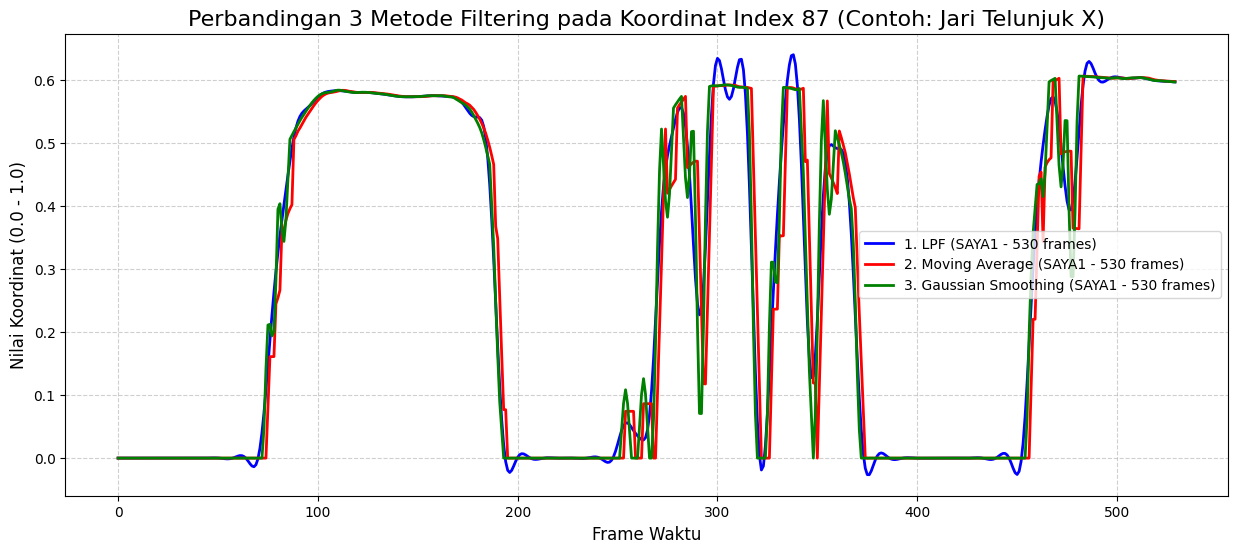


--- Kesimpulan Visual ---
Cari dua hal di plot ini:
1. Kehalusan (Smoothness): Garis mana yang paling sedikit 'gerigi' (noise)?
2. Akurasi Temporal (Time Lag): Apakah ada garis yang terlihat terlambat (bergeser ke kanan) dibandingkan garis lainnya?

Filter LPF (biru) diharapkan menunjukkan kehalusan terbaik tanpa lag (zero-phase), menjadikannya ideal untuk LSTM.


In [25]:
# --- 4. VISUALISASI PERBANDINGAN ---
plt.figure(figsize=(15, 6))
plt.title(f'Perbandingan 3 Metode Filtering pada Koordinat Index {COORDINATE_INDEX} (Contoh: Jari Telunjuk X)', fontsize=16)
plt.xlabel('Frame Waktu', fontsize=12)
plt.ylabel('Nilai Koordinat (0.0 - 1.0)', fontsize=12)

# Plot Low-Pass Filter (LPF)
plt.plot(signal_lpf, label=f'1. LPF (SAYA1 - {len(signal_lpf)} frames)', color='blue', linewidth=2)

# Plot Moving Average (MA)
plt.plot(signal_ma, label=f'2. Moving Average (SAYA1 - {len(signal_ma)} frames)', color='red', linewidth=2)

# Plot Gaussian Smoothing
plt.plot(signal_gaussian, label=f'3. Gaussian Smoothing (SAYA1 - {len(signal_gaussian)} frames)', color='green', linewidth=2)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n--- Kesimpulan Visual ---")
print("Cari dua hal di plot ini:")
print("1. Kehalusan (Smoothness): Garis mana yang paling sedikit 'gerigi' (noise)?")
print("2. Akurasi Temporal (Time Lag): Apakah ada garis yang terlihat terlambat (bergeser ke kanan) dibandingkan garis lainnya?")
print("\nFilter LPF (biru) diharapkan menunjukkan kehalusan terbaik tanpa lag (zero-phase), menjadikannya ideal untuk LSTM.")

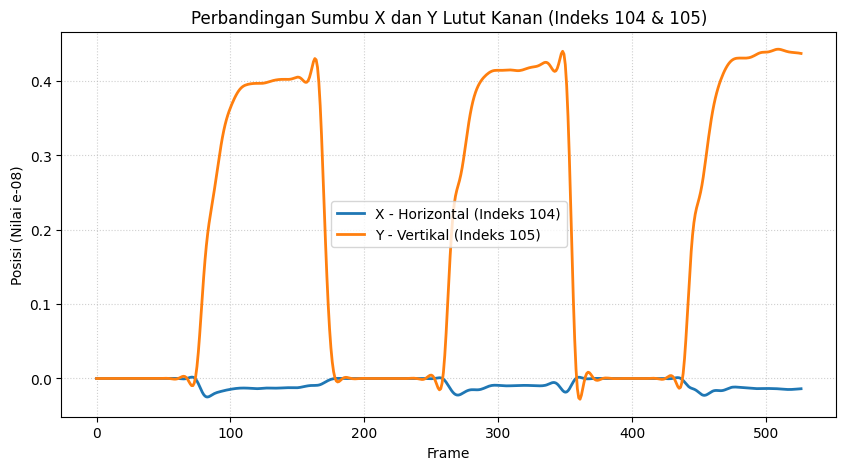

In [ ]:
#NENTUIN INDEX BIAR BISA DIAKUIN FFT 
import numpy as np
import matplotlib.pyplot as plt
import os

# GANTI PATH ini jika Anda belum melakukannya
DATA_FOLDER = r"D:\PSD_UAS" 
SAMPLE_FILE_NAME = 'LPF_BERSIH_MAAF1.npy'
SAMPLE_FILE_PATH = os.path.join(DATA_FOLDER, SAMPLE_FILE_NAME)

try:
    data = np.load(SAMPLE_FILE_PATH)
    
    # Asumsi Indeks Lutut Kanan (berdasarkan konvensi 4N)
    KNEE_R_X_INDEX = 104 # Lutut Kanan X (Horizontal)
    KNEE_R_Y_INDEX = 105 # Lutut Kanan Y (Vertical)
    
    plt.figure(figsize=(10, 5))
    plt.title("Perbandingan Sumbu X dan Y Lutut Kanan (Indeks 104 & 105)")
    
    # Plot X
    plt.plot(data[:, KNEE_R_X_INDEX], label=f'X - Horizontal (Indeks 104)', linewidth=2)
    
    # Plot Y
    plt.plot(data[:, KNEE_R_Y_INDEX], label=f'Y - Vertikal (Indeks 105)', linewidth=2)
    
    plt.legend()
    plt.xlabel("Frame")
    plt.ylabel("Posisi (Nilai e-08)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

except Exception as e:
    print(f"Terjadi error saat plotting: {e}")

FFT

In [ ]:

import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import os

def analyze_fft_metrics(signal, fs):
    N = len(signal)
    if N < 2: return {'frequency': np.nan, 'amplitude': np.nan}
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    psd = 2.0/N * np.abs(yf[0:N//2])
    
    idx_dominant = np.argmax(psd)
    dominant_frequency = xf[idx_dominant]
    dominant_amplitude = psd[idx_dominant]
    return {
        'frequency': dominant_frequency,
        'amplitude': dominant_amplitude
    }

# --- 3. PARAMETER GLOBAL (SESUAIKAN) ---
FS = 30  # Sampling Frequency (FPS video Anda)


SINYAL_COLUMN_INDEX = 105

FILE_EXTENSION = '.npy' 
DATA_FOLDER = r"D:\PSD_UAS" 

# --- FILE MAPPING YANG DIREVISI ---
# Kunci luar adalah NAMA VIDEO (MAAF, IYA, dll.)
# Kunci dalam adalah METODE (LPF, MA, Gaussian)
FILE_MAPPING = {
    'MAAF': {
        'LPF': 'LPF_BERSIH_MAAF1.npy',
        'MA': 'MA_BERSIH_MAAF1.npy',       
        'Gaussian': 'GAUSSIAN_BERSIH_MAAF1.npy'
    },
    'IYA': {
        'LPF': 'LPF_BERSIH_IYA1.npy', 
        'MA': 'MA_BERSIH_IYA1.npy',       
        'Gaussian': 'GAUSSIAN_BERSIH_IYA1.npy' 
    },
    'TOLONG': {
        'LPF': 'LPF_BERSIH_TOLONG1.npy',
        'MA': 'MA_BERSIH_TOLONG1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_TOLONG1.npy'
    },
    'TERIMAKASIH': {
        'LPF': 'LPF_BERSIH_TERIMAKASIH1.npy',
        'MA': 'MA_BERSIH_TERIMAKASIH1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_TERIMAKASIH.npy'
    },
    'SAYA': {
        'LPF': 'LPF_BERSIH_SAYA1.npy',
        'MA': 'MA_BERSIH_SAYA1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_SAYA1.npy'
    }
}

all_results = []

In [ ]:
#NUMERIK NYA MUNCUL DISINI
import numpy as np
import pandas as pd
import os
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Menerapkan filter Butterworth Bandpass dua arah (filtfilt)"""
    nyq = 0.5 * fs # Frekuensi Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    
    # Menghitung koefisien filter
    b, a = butter(order, [low, high], btype='band')
    
    # Menerapkan filter (filtfilt mencegah pergeseran fase)
    y = filtfilt(b, a, data)
    return y
# ==========================================================
# --- 1. DEFINISI KONSTANTA DAN KONFIGURASI AWAL ---
# ==========================================================

# PASTIKAN Anda memiliki folder ini dan file .npy di dalamnya
DATA_FOLDER = 'D:\PSD_UAS' 

# Frekuensi Sampling (misalnya 30Hz untuk video 30fps)
FS = 30 

# Indeks kolom yang berisi data sinyal (misalnya kolom kedua/indeks 1)
SINYAL_COLUMN_INDEX = 1 

# Pemetaan File: Ganti dengan pemetaan file Anda yang sebenarnya
FILE_MAPPING = {
    'MAAF': {
        'LPF': 'LPF_BERSIH_MAAF1.npy',
        'MA': 'MA_BERSIH_MAAF1.npy',       
        'Gaussian': 'GAUSSIAN_BERSIH_MAAF1.npy'
    },
    'IYA': {
        'LPF': 'LPF_BERSIH_IYA1.npy', 
        'MA': 'MA_BERSIH_IYA1.npy',       
        'Gaussian': 'GAUSSIAN_BERSIH_IYA1.npy' 
    },
    'TOLONG': {
        'LPF': 'LPF_BERSIH_TOLONG1.npy',
        'MA': 'MA_BERSIH_TOLONG1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_TOLONG1.npy'
    },
    'TERIMAKASIH': {
        'LPF': 'LPF_BERSIH_TERIMAKASIH1.npy',
        'MA': 'MA_BERSIH_TERIMAKASIH1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_TERIMAKASIH.npy'
    },
    'SAYA': {
        'LPF': 'LPF_BERSIH_SAYA1.npy',
        'MA': 'MA_BERSIH_SAYA1.npy',
        'Gaussian': 'GAUSSIAN_BERSIH_SAYA1.npy'
    }
    # Pastikan FILE_MAPPING sudah diperbarui sesuai log file yang Anda kirim
}

all_results = []
os.makedirs(DATA_FOLDER, exist_ok=True) 

# ==========================================================
# --- 2. FUNGSI UNTUK ANALISIS FFT DAN METRIK (FIXED: 0.5 Hz) ---
# ==========================================================

def analyze_fft_metrics(signal, fs):
    """
    Menghitung Dominant Frequency dan Amplitudo dari sinyal menggunakan FFT.
    Batas Frekuensi Minimum diubah menjadi 0.5 Hz.
    """
    
    # 🚨 PERUBAHAN: Batas Frekuensi Minimum diturunkan menjadi 0.5 Hz
    MIN_RELEVANT_HZ = 0.5 
    
    # Detrending (Menghilangkan komponen DC/rata-rata)
    signal_detrended = signal - np.mean(signal) 
    
    N = len(signal_detrended)
    
    # 1. Hitung FFT dan Frekuensi
    yf = fft(signal_detrended)
    xf = fftfreq(N, 1 / fs)[:N//2]
    psd = 2.0/N * np.abs(yf[0:N//2]) 
    
    # 2. Tentukan Rentang Pencarian Indeks
    # Mencari indeks xf yang nilainya >= MIN_RELEVANT_HZ
    start_index = np.argmin(np.abs(xf - MIN_RELEVANT_HZ))
    
    # Pastikan start_index setidaknya 1 (mengabaikan 0 Hz)
    if start_index == 0:
        start_index = 1
        
    # 3. Cari Indeks Frekuensi Dominan HANYA dalam rentang yang relevan
    dominant_index = np.argmax(psd[start_index:]) + start_index
    
    # 4. Ekstraksi Metrik
    dominant_frequency = xf[dominant_index]
    dominant_amplitude = psd[dominant_index]

    # Cek Tambahan: Jika dominan amplitudo terlalu kecil (misalnya < 0.000001)
    if dominant_amplitude < 1e-6: 
         print(f" [INFO] Sinyal dominan lemah di atas {MIN_RELEVANT_HZ} Hz.")
    
    return {
        'frequency': dominant_frequency, 
        'amplitude': dominant_amplitude
    }

# ==========================================================
# --- 3. FUNGSI UNTUK MEMBACA DATA .NPY (Error Handling) ---
# ==========================================================
# (Tidak ada perubahan di sini, kode ini sudah benar)
def load_data(file_name):
    """Membaca data dari file .npy dan memilih kolom sinyal berdasarkan indeks."""
    file_path = os.path.join(DATA_FOLDER, file_name)
    print(f"Loading {file_name}...")
    
    try:
        data_array = np.load(file_path, allow_pickle=True)
        
        if data_array.ndim != 2:
            print(f"Error: {file_name} bukan array 2D ({data_array.ndim}D). Skipping.")
            return np.array([])
            
        signal = data_array[:, SINYAL_COLUMN_INDEX] 
        return signal
        
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Skipping.")
        return np.array([]) 
    except IndexError:
        n_cols = data_array.shape[1] if 'data_array' in locals() and data_array.ndim == 2 else 0
        print(f"Error: Indeks kolom sinyal ({SINYAL_COLUMN_INDEX}) di luar batas (0-{n_cols-1}). Skipping.")
        return np.array([])
    except Exception as e:
        print(f"Terjadi error saat memuat atau memproses file: {e}. Skipping.")
        return np.array([])

# ==========================================================
# --- 4. LOOPING ANALISIS BERDASARKAN METODE DAN VIDEO ---
# ==========================================================

# [di dalam LOOPING ANALISIS BERDASARKAN METODE DAN VIDEO (Bagian 4)]

for video_name, methods in FILE_MAPPING.items():
    for method_name, file_name in methods.items():
        
        signal_data = load_data(file_name) 
        
        if len(signal_data) == 0 or np.all(np.isnan(signal_data)):
            continue
            
        # --- [MODIFIKASI BARU: Terapkan Bandpass Filter] ---
        # Asumsi: Sinyal yang dicari (misalnya Denyut Nadi/Gerakan) ada di rentang 0.5 Hz hingga 3.0 Hz
        signal_filtered_bp = butter_bandpass_filter(signal_data, 
                                                    lowcut=0.5, 
                                                    highcut=3.0, 
                                                    fs=FS)
        # ---------------------------------------------------

        # Analisis FFT menggunakan sinyal yang sudah di Bandpass
        # Gunakan sinyal yang sudah di-bandpass untuk FFT
        metrics = analyze_fft_metrics(signal_filtered_bp, FS) 
        
        # ... (lanjutkan menyimpan all_results dan all_psd_data)
        # ...
print("\nMemulai Analisis Data Sinyal...")
for video_name, methods in FILE_MAPPING.items():
    for method_name, file_name in methods.items():
        
        signal_data = load_data(file_name) 
        
        if len(signal_data) == 0 or np.all(np.isnan(signal_data)):
            continue

        metrics = analyze_fft_metrics(signal_data, FS)
        
        all_results.append({
            'Metode': method_name,       
            'Video': video_name,         
            'Dominant_Frequency (Hz)': metrics['frequency'], 
            'Dominant_Amplitude (PSD)': metrics['amplitude']
        })
        
# FIX: Menjamin kolom ada
df_results = pd.DataFrame(all_results, columns=[
    'Metode', 'Video', 'Dominant_Frequency (Hz)', 'Dominant_Amplitude (PSD)'
])
print("\n" + "="*50)
print("--- HASIL NUMERIK TIAP METODE UNTUK SETIAP VIDEO ---")
print("="*50)
print(df_results)
print("="*50)

# ==========================================================
# --- 5. RATA-RATA AKHIR (KESIMPULAN NUMERIK) ---
# ==========================================================

# FIX: Guard Clause untuk menghindari KeyError pada DataFrame kosong
if df_results.empty:
    print("\n[PERINGATAN] Data hasil kosong. Tidak dapat menghitung rata-rata metode.")
else:
    df_avg = df_results.groupby('Metode').agg({
        'Dominant_Frequency (Hz)': ['mean', 'std'],
        'Dominant_Amplitude (PSD)': ['mean', 'std']
    }).reset_index()

    df_avg.columns = ['Metode', 'Avg_Frequency (Hz)', 'Std_Frequency (Hz)', 
                      'Avg_Amplitude (PSD)', 'Std_Amplitude (PSD)']

    print("\n" + "="*70)
    print("--- KESIMPULAN NUMERIK RATA-RATA PER METODE ---")
    print("="*70)
    print(df_avg)
    print("="*70)

Loading LPF_BERSIH_MAAF1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading MA_BERSIH_MAAF1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading GAUSSIAN_BERSIH_MAAF1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading LPF_BERSIH_IYA1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading MA_BERSIH_IYA1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading GAUSSIAN_BERSIH_IYA1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading LPF_BERSIH_TOLONG1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading MA_BERSIH_TOLONG1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading GAUSSIAN_BERSIH_TOLONG1.npy...
 [INFO] Sinyal dominan lemah di atas 0.5 Hz.
Loading LPF_BERSIH_TERIMAKASIH1.npy...
Loading MA_BERSIH_TERIMAKASIH1.npy...
Loading GAUSSIAN_BERSIH_TERIMAKASIH.npy...
Loading LPF_BERSIH_SAYA1.npy...
Loading MA_BERSIH_SAYA1.npy...
Loading GAUSSIAN_BERSIH_SAYA1.npy...

Memulai Analisis Data Sinyal...
Loading LPF_BERSIH_MAAF1.npy...
 [INFO]

<>:25: SyntaxWarning: invalid escape sequence '\P'
<>:25: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ARIMBY\AppData\Local\Temp\ipykernel_25476\3189416509.py:25: SyntaxWarning: invalid escape sequence '\P'
  DATA_FOLDER = 'D:\PSD_UAS'



Memulai pembuatan grafik PSD...


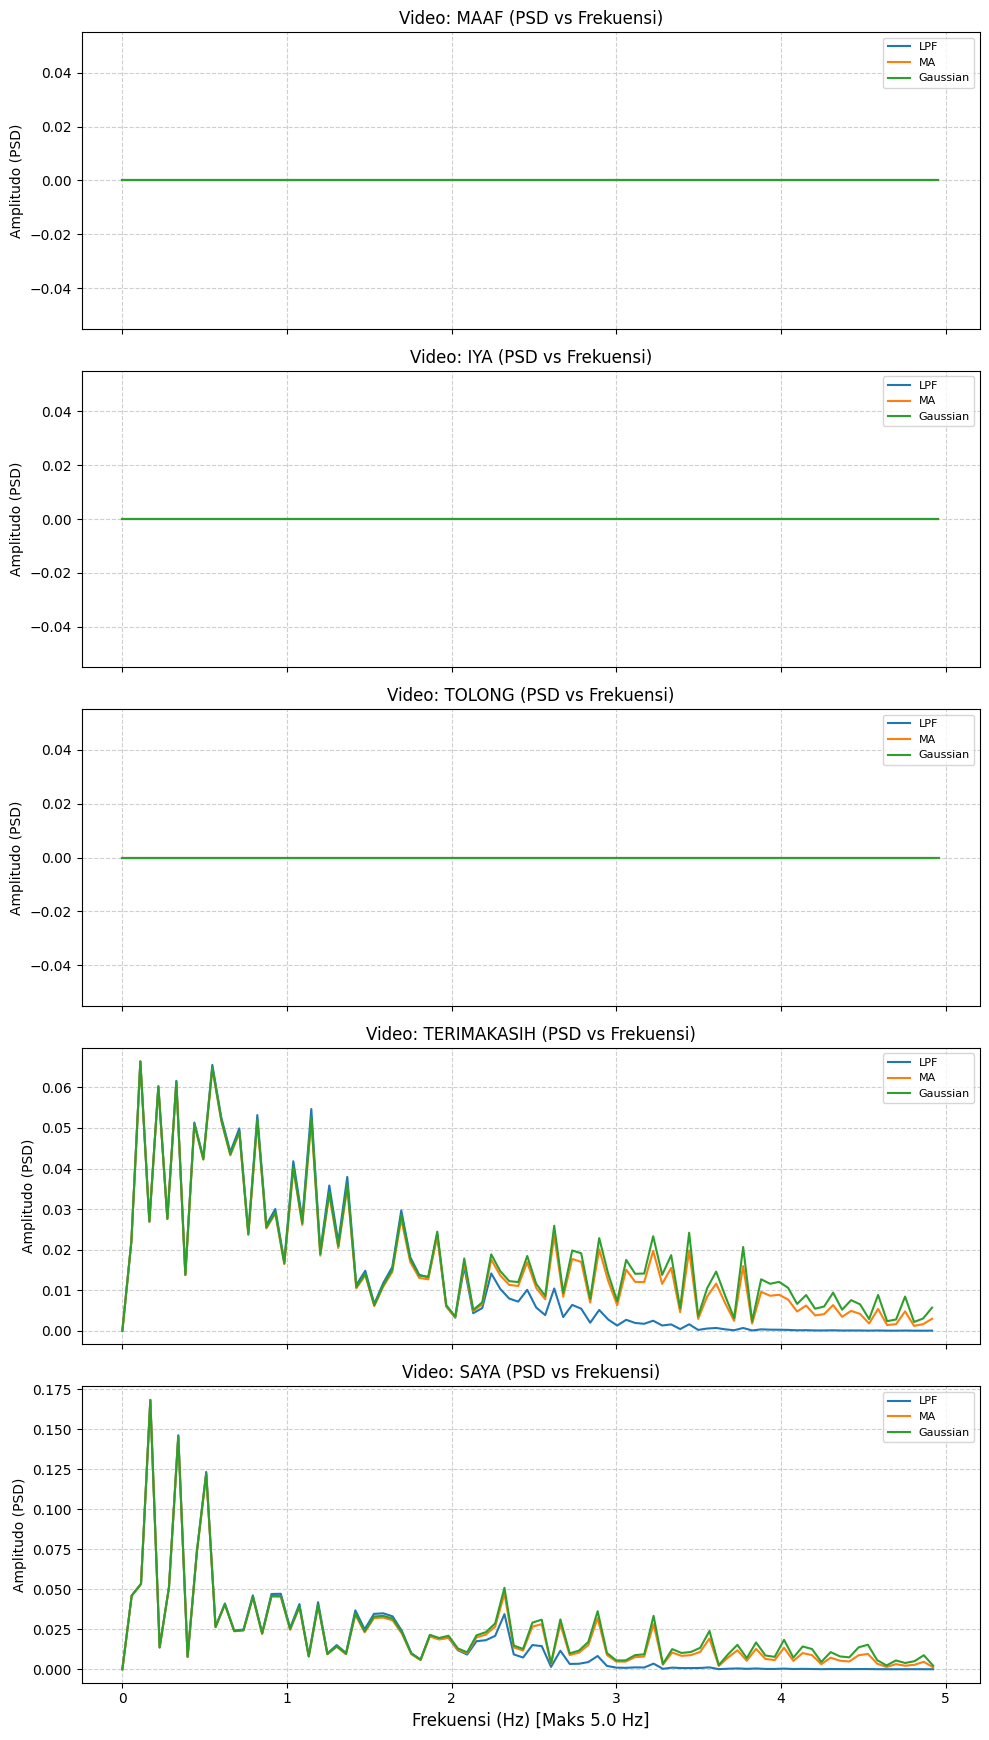

In [ ]:
#DIKASIH VISUALIASI BIAR KLIATAN KLO EMG SINYAL NYA ADA YG LEMAH
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan library 'matplotlib' sudah terinstal: pip install matplotlib

# ==========================================================
# --- 1. KONFIGURASI FILE ---
# ==========================================================

# Nama file yang dihasilkan oleh script analisis sebelumnya
PSD_DATA_FILE = 'psd_data_for_plotting.npy'
# Batas frekuensi maksimum yang ingin ditampilkan di plot (misalnya sampai 5 Hz)
MAX_PLOT_HZ = 5.0 

# ==========================================================
# --- 2. FUNGSI UNTUK MEMPLOT ---
# ==========================================================

def plot_psd_comparison(psd_data):
    """
    Membuat plot perbandingan PSD (Power Spectral Density) 
    untuk setiap Video, membandingkan tiga metode filtering.
    """
    
    # Mengelompokkan data berdasarkan Video
    grouped_data = {}
    for item in psd_data:
        video = item['Video']
        if video not in grouped_data:
            grouped_data[video] = []
        grouped_data[video].append(item)

    # Membuat figure: 5 video, 1 kolom
    num_videos = len(grouped_data)
    # Atur ukuran figure
    fig, axes = plt.subplots(nrows=num_videos, ncols=1, figsize=(10, 3.5 * num_videos), 
                             sharex=True)
    
    if num_videos == 1:
        axes = [axes]

    print("\nMemulai pembuatan grafik PSD...")

    for i, (video_name, data_list) in enumerate(grouped_data.items()):
        ax = axes[i]
        
        for data in data_list:
            method_name = data['Metode']
            xf = data['Frequency_Array']
            psd = data['PSD_Array']
            
            # Batasi data plot hingga MAX_PLOT_HZ
            max_idx = np.argmin(np.abs(xf - MAX_PLOT_HZ))

            # Plot garis PSD
            ax.plot(xf[:max_idx], psd[:max_idx], label=method_name, 
                    linewidth=1.5)
            
        ax.set_title(f'Video: {video_name} (PSD vs Frekuensi)', fontsize=12)
        ax.set_ylabel('Amplitudo (PSD)', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper right', fontsize=8)
    
    axes[-1].set_xlabel(f'Frekuensi (Hz) [Maks {MAX_PLOT_HZ} Hz]', fontsize=12)
    plt.tight_layout()
    plt.show() # Tampilkan jendela plot

# ==========================================================
# --- 3. EKSEKUSI UTAMA ---
# ==========================================================

try:
    # Memuat data PSD yang disimpan
    psd_data = np.load(PSD_DATA_FILE, allow_pickle=True)
    
    if len(psd_data) == 0:
        print(f"Error: File '{PSD_DATA_FILE}' kosong atau tidak mengandung data.")
    else:
        plot_psd_comparison(psd_data)
        
except FileNotFoundError:
    print(f"Error: File '{PSD_DATA_FILE}' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan script analisis FFT Anda terlebih dahulu.")
except Exception as e:
    print(f"Terjadi error saat memuat atau memproses data PSD: {e}")